<a href="https://colab.research.google.com/github/FadzararAI/Weather-related-Disease-Prediction/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Importing

In [ ]:
# Classifier Graphing
!pip install graphviz
!pip install kaggle

In [ ]:
# For Data Manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# For Data cleaning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# For Machine Learning
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, log_loss, precision_recall_curve, auc,
                            confusion_matrix, classification_report, roc_curve)
from xgboost import XGBClassifier, plot_tree, to_graphviz, plot_importance
import time

# Dataset Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Weather-related disease prediction.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache,prognosis
0,4,1,25.826,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.628,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.800,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.254,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.162,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


In [ ]:
# Download the CSV to Colab's local environment
column_names = ['Age', 'Gender', 'Temperature', 'Humidity', 'Wind_speed', 'prognosis']
weather_dis = pd.read_csv("/content/drive/My Drive/Weather-related disease prediction.csv")

# View the first few rows
weather_dis.head()

,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache,prognosis
0,4,1,25.826,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.628,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.800,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.254,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.162,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis


## Dataset Cleaning and Engineering

## Label Encoding

In [ ]:
#Label encode
X = weather_dis.drop('prognosis', axis=1)
y = weather_dis['prognosis']

categorical_cols = ['Gender']

x_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = x_encoder.fit_transform(X[categorical_cols])
encoded_gender_df = pd.DataFrame(X_encoded, columns=x_encoder.get_feature_names_out(categorical_cols))
X_final = pd.concat([X.drop(columns=categorical_cols).reset_index(drop=True),
               encoded_gender_df.reset_index(drop=True)], axis=1)


y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

categories_df = pd.DataFrame({
    'prognosis_categories': y_encoder.classes_,
    'encoded_label': list(range(len(y_encoder.classes_)))
})

final_df = pd.concat([X_final, pd.Series(y_encoded, name='prognosis_encoded')],axis=1)

print(final_df.head())
print("\n===== Prognosis Label Mapping =====")
print(categories_df)

   Age  Temperature (C)  Humidity  Wind Speed (km/h)  nausea  joint_pain  \
0    4           25.826  0.740000           8.289000       1           0   
1   55           21.628  0.600000          15.236000       0           0   
2   45           13.800  0.817083           4.291992       0           0   
3    6           37.254  0.610000          18.009000       1           0   
4   70           18.162  0.870000          17.916000       0           0   

   abdominal_pain  high_fever  chills  fatigue  ...  shortness_of_breath  \
0               0           0       0        0  ...                    1   
1               0           0       1        1  ...                    0   
2               0           0       0        0  ...                    0   
3               0           1       0        0  ...                    0   
4               0           0       0        0  ...                    0   

   reduced_smell_and_taste  skin_irritation  itchiness  throbbing_headache  \
0       

In [ ]:
unique_prognosis = np.unique(y)
print("Unique Prognosis:", unique_prognosis)

Unique Prognosis: ['Arthritis' 'Common Cold' 'Dengue' 'Eczema' 'Heart Attack' 'Heat Stroke'
 'Influenza' 'Malaria' 'Migraine' 'Sinusitis' 'Stroke']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, final_df["prognosis_encoded"], test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
#y_train_labels = np.argmax(y_train, axis=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#y_train_smote = pd.get_dummies(y_train_labels_smote).values

print("Before Oversampling:", X_train.shape, y_train.shape)
print("After Oversampling:", X_train_smote.shape, y_train_smote.shape)
print("Test Set:", X_test.shape, y_test.shape)

Before Oversampling: (3640, 50) (3640,)
After Oversampling: (7799, 50) (7799,)
Test Set: (1560, 50) (1560,)


In [ ]:
# Before oversampling
print("Before Oversampling (y_train):")
print(y_train.value_counts())

# After oversampling
print("\nAfter Oversampling (y_train_smote):")
print(pd.Series(y_train_smote).value_counts())

# Test set
print("\nTest Set (y_test):")
print(y_test.value_counts())

Before Oversampling (y_train):
prognosis_encoded
4     709
8     659
6     461
5     236
7     231
10    230
3     229
1     225
2     225
0     218
9     217
Name: count, dtype: int64

After Oversampling (y_train_smote):
prognosis_encoded
8     709
10    709
6     709
7     709
4     709
0     709
5     709
2     709
3     709
1     709
9     709
Name: count, dtype: int64

Test Set (y_test):
prognosis_encoded
4     304
8     282
6     197
5     102
7      99
10     99
3      98
2      97
1      96
0      93
9      93
Name: count, dtype: int64


# Prediction using XGBoost

## Model Defining and Training

In [ ]:
model = XGBClassifier(eval_metric='merror', max_depth = 6, gamma = 0, min_child_weight = 6, n_estimators = 177, learning_rate = 0.01)

In [ ]:
model.fit(X_train_smote, y_train_smote, eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=177,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
predicted = model.predict(X_test)

## Model Evaluation

In [ ]:
accuracy_score(predicted, y_test)

0.9673076923076923

In [ ]:
print(classification_report(y_test, predicted, target_names=y_encoder.classes_))

              precision    recall  f1-score   support

   Arthritis       1.00      1.00      1.00        93
 Common Cold       0.88      0.98      0.93        96
      Dengue       0.95      0.99      0.97        97
      Eczema       0.98      1.00      0.99        98
Heart Attack       1.00      0.99      1.00       304
 Heat Stroke       0.92      0.95      0.94       102
   Influenza       0.98      0.89      0.93       197
     Malaria       0.91      0.99      0.95        99
    Migraine       0.99      0.94      0.97       282
   Sinusitis       0.99      1.00      0.99        93
      Stroke       0.95      0.97      0.96        99

    accuracy                           0.97      1560
   macro avg       0.96      0.97      0.97      1560
weighted avg       0.97      0.97      0.97      1560



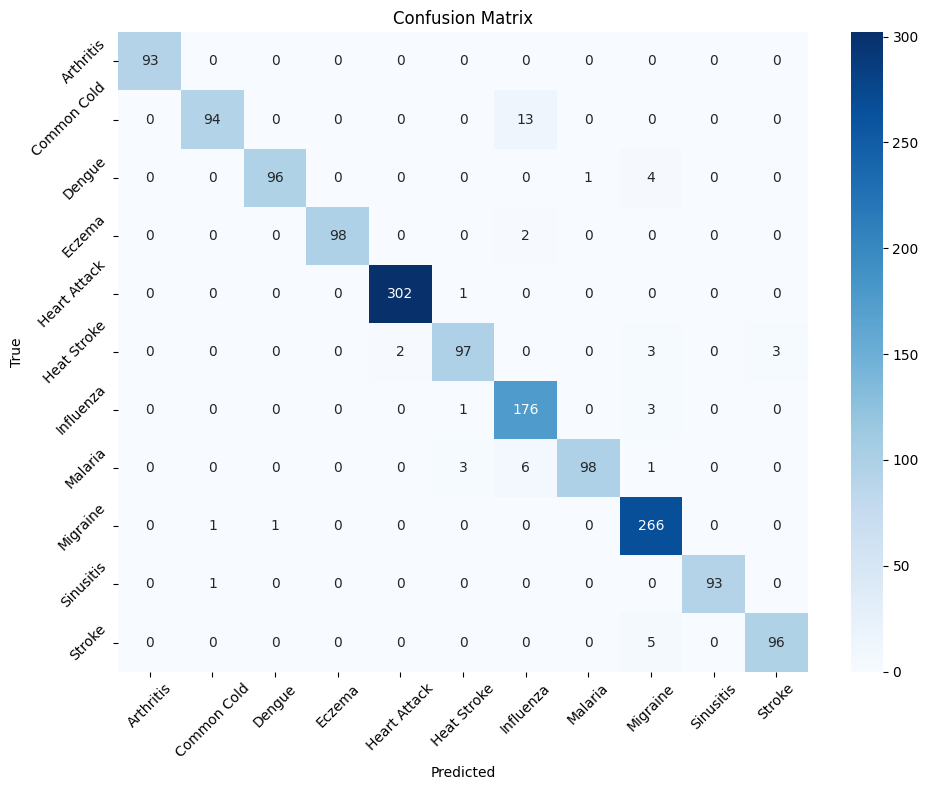

In [ ]:
cm = confusion_matrix(predicted, y_test)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_encoder.classes_,
            yticklabels=y_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

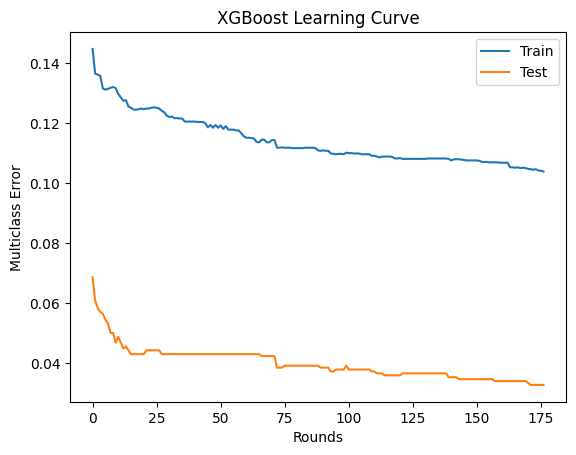

In [ ]:
results = model.evals_result()
plt.plot(results['validation_0']['merror'], label='Train')
plt.plot(results['validation_1']['merror'], label='Test')
plt.xlabel("Rounds")
plt.ylabel("Multiclass Error")
plt.title("XGBoost Learning Curve")
plt.legend()

<Figure size 3000x2000 with 0 Axes>

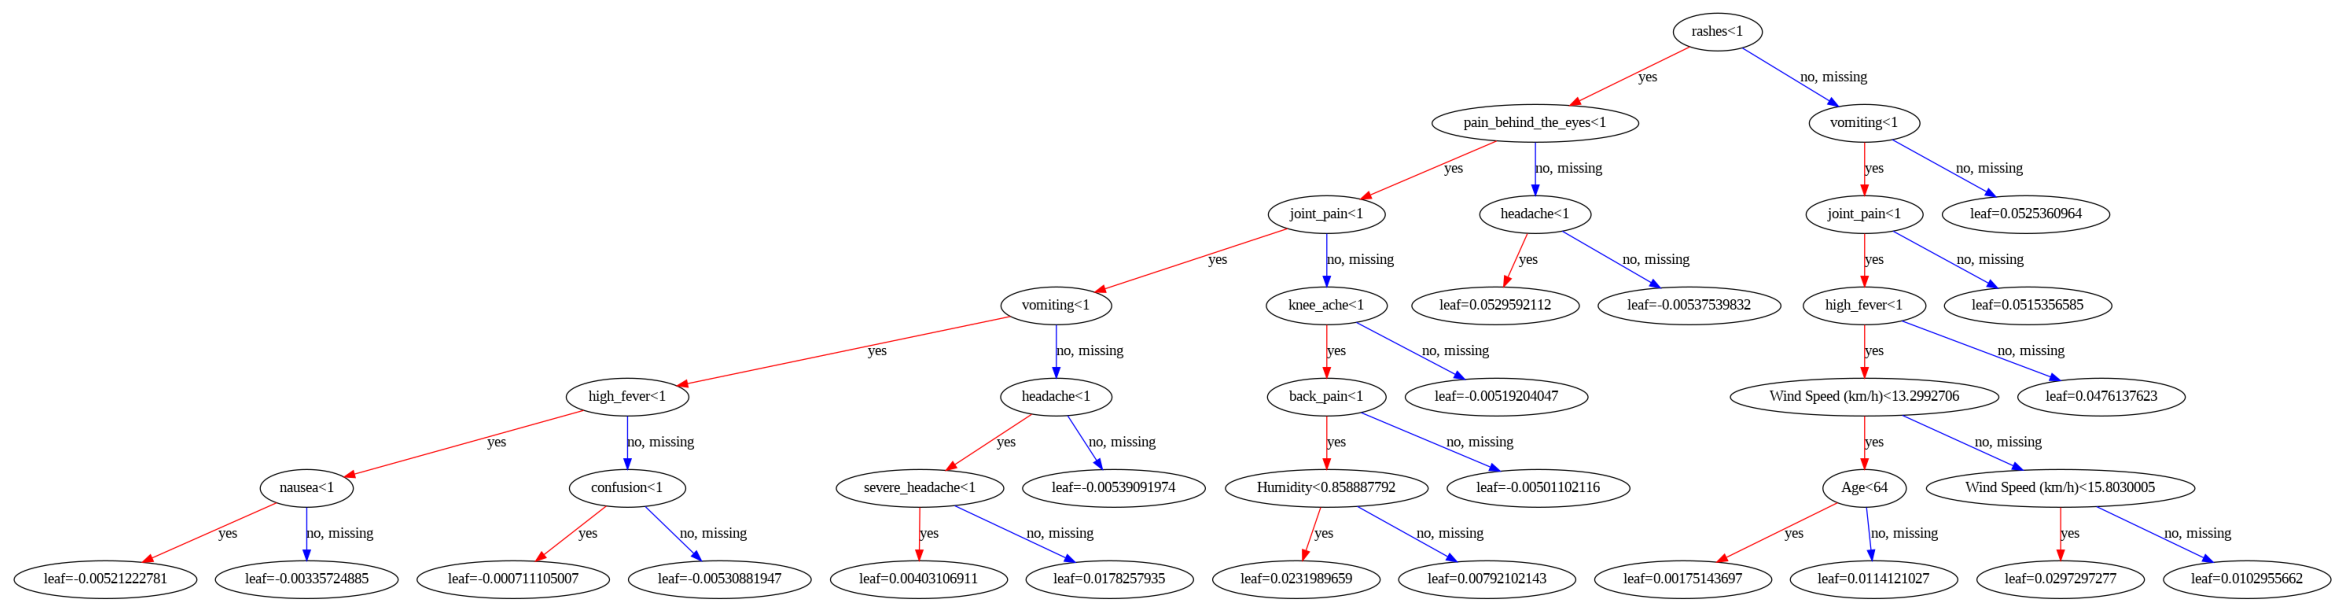

In [ ]:
booster = model.get_booster()
plt.figure(figsize=(30, 20))
plot_tree(model, num_trees=2)

# To save the plot as a file
fig = plt.gcf()
fig.set_size_inches(30, 15)
fig.savefig("xgb_tree_21.png")

plt.show()

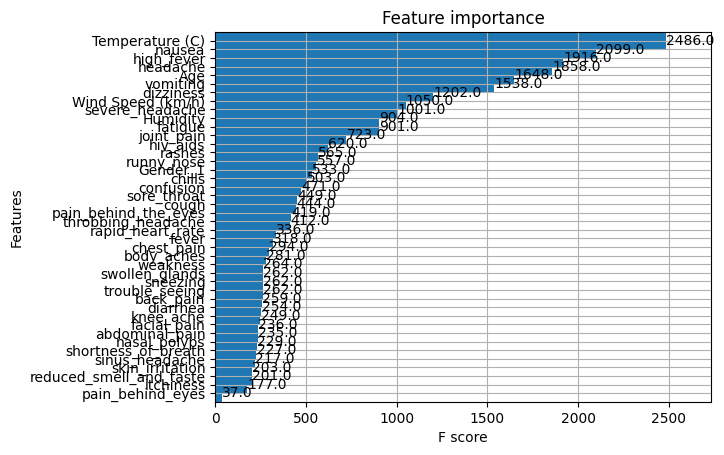

In [ ]:
plot_importance(booster, height=2)
plt.show()

# Model Utilization

In [ ]:
probas = model.predict_proba(X_test)

In [ ]:
class_names = y_encoder.classes_
top3_list = []
for i in range(len(X_test)):
    top3_idx = np.argsort(probas[i])[-3:][::-1]
    top3_diseases = class_names[top3_idx]
    top3_probs = probas[i][top3_idx]
    top3_list.append({
        'Patient_Index': i,
        'Top_1': f"{top3_diseases[0]} ({top3_probs[0]*100:.2f}%)",
        'Top_2': f"{top3_diseases[1]} ({top3_probs[1]*100:.2f}%)",
        'Top_3': f"{top3_diseases[2]} ({top3_probs[2]*100:.2f}%)"
    })

In [ ]:
top3_df = pd.DataFrame(top3_list)
top3_df.head(20)

,Patient_Index,Top_1,Top_2,Top_3
0,0,Dengue (65.99%),Arthritis (6.77%),Influenza (5.30%)
1,1,Heart Attack (70.12%),Heat Stroke (6.48%),Dengue (3.66%)
2,2,Heart Attack (74.18%),Influenza (3.32%),Common Cold (2.85%)
3,3,Arthritis (51.71%),Dengue (9.40%),Common Cold (7.81%)
4,4,Heart Attack (74.26%),Influenza (3.33%),Eczema (2.74%)
5,5,Malaria (69.81%),Dengue (9.25%),Stroke (2.81%)
6,6,Malaria (70.01%),Influenza (8.37%),Migraine (2.96%)
7,7,Influenza (49.41%),Sinusitis (10.71%),Common Cold (7.99%)
8,8,Arthritis (68.99%),Dengue (4.25%),Malaria (4.14%)
9,9,Dengue (61.80%),Arthritis (13.46%),Influenza (6.55%)


# Comparing with another ML model

## Using SVM and Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
np.random.seed(42)
# Initialize models with some tuned parameters for maximum comparisons
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8,
                   colsample_bytree=0.8, random_state=42, n_jobs=-1)

In [ ]:
# Dictionary to store model results
models = {'Random Forest': rf, 'SVM': svm, 'XGBoost': xgb}
results = {}

In [ ]:
# Function to evaluate and compare models
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    # Measure training time
    start_time = time.time()

    # Check if the model supports eval_set (like XGBoost, LightGBM)
    if hasattr(model, 'fit') and 'eval_set' in model.fit.__code__.co_varnames:
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)

    train_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Check if binary or multiclass
    unique_classes = np.unique(y_test)
    n_classes = len(unique_classes)
    is_binary = n_classes == 2

    # Set the average parameter for multiclass metrics
    avg = 'binary' if is_binary else 'weighted'

    # Calculate various metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=avg)
    rec = recall_score(y_test, y_pred, average=avg)
    f1 = f1_score(y_test, y_pred, average=avg)

    # Initialize results dictionary with metrics that always exist
    results = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Training Time': train_time,
        'Model': model,
        'ROC AUC': None,
        'PR AUC': None,
        'Log Loss': None,
        'CV Std': None,
        'y_prob': None,  # Initialize y_prob with None
        'is_binary': is_binary,  # Store whether this is binary classification
        'classes': unique_classes  # Store class labels
    }

    # Add probability-based metrics only if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        try:
            y_prob = model.predict_proba(X_test)

            if is_binary:
                # Binary classification case
                y_prob_binary = y_prob[:, 1]
                roc = roc_auc_score(y_test, y_prob_binary)
                loss = log_loss(y_test, y_prob)

                # Precision-Recall AUC
                precision, recall, _ = precision_recall_curve(y_test, y_prob_binary)
                pr_auc = auc(recall, precision)

                results['ROC AUC'] = roc
                results['PR AUC'] = pr_auc
                results['Log Loss'] = loss
                results['y_prob'] = y_prob_binary
            else:
                # Multiclass case
                try:
                    # For multiclass ROC, we use OvR (One-vs-Rest)
                    roc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
                    loss = log_loss(y_test, y_prob)

                    results['ROC AUC'] = roc
                    results['Log Loss'] = loss
                    # Store all class probabilities for multiclass
                    results['y_prob'] = y_prob
                except Exception as e:
                    print(f"Warning for {name}: Could not calculate multiclass metrics: {e}")
        except Exception as e:
            print(f"Warning for {name}: Could not calculate probability-based metrics: {e}")

    # Cross-validation for stability assessment
    try:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        cv_std = cv_scores.std()
        results['CV Std'] = cv_std
    except Exception as e:
        print(f"Warning for {name}: Could not perform cross-validation: {e}")

    # Store results for this model
    all_results = {}
    all_results[name] = results

    # Print results
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Only print metrics if they have valid values
    if results['ROC AUC'] is not None:
        print(f"ROC AUC: {results['ROC AUC']:.4f}")
    if results['PR AUC'] is not None:
        print(f"PR AUC: {results['PR AUC']:.4f}")
    if results['Log Loss'] is not None:
        print(f"Log Loss: {results['Log Loss']:.4f}")
    if results['CV Std'] is not None:
        print(f"CV Accuracy Std: {results['CV Std']:.4f}")

    print(f"Training Time: {train_time:.4f} seconds")

    return all_results

In [ ]:
# Evaluate each model using SMOTE-balanced training data
results = {}  # Initialize results dictionary before the loop
for name, model in models.items():
    model_results = evaluate_model(name, model, X_train_smote, X_test, y_train_smote, y_test)
    results.update(model_results)


Random Forest Evaluation:
Accuracy: 0.9083
Precision: 0.9227
Recall: 0.9083
F1 Score: 0.9110
ROC AUC: 0.9933
Log Loss: 1.0098
CV Accuracy Std: 0.0130
Training Time: 0.5199 seconds

SVM Evaluation:
Accuracy: 0.3654
Precision: 0.3705
Recall: 0.3654
F1 Score: 0.3276
ROC AUC: 0.7729
Log Loss: 1.9920
CV Accuracy Std: 0.0087
Training Time: 32.6417 seconds

XGBoost Evaluation:
Accuracy: 0.9814
Precision: 0.9818
Recall: 0.9814
F1 Score: 0.9815
ROC AUC: 0.9997
Log Loss: 0.0876
CV Accuracy Std: 0.0079
Training Time: 2.1187 seconds


In [ ]:
# Create comparison visualizations
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
if all(results[model_name]['ROC AUC'] is not None for model_name in models.keys()):
    metrics.append('ROC AUC')
if all(results[model_name]['PR AUC'] is not None for model_name in models.keys()):
    metrics.append('PR AUC')

# Extract results for plotting
df_results = pd.DataFrame({
    model_name: {metric: results[model_name][metric] for metric in metrics if results[model_name][metric] is not None}
    for model_name in models.keys()
}).T

## Comparison Results Visualizations

<Figure size 1400x800 with 0 Axes>

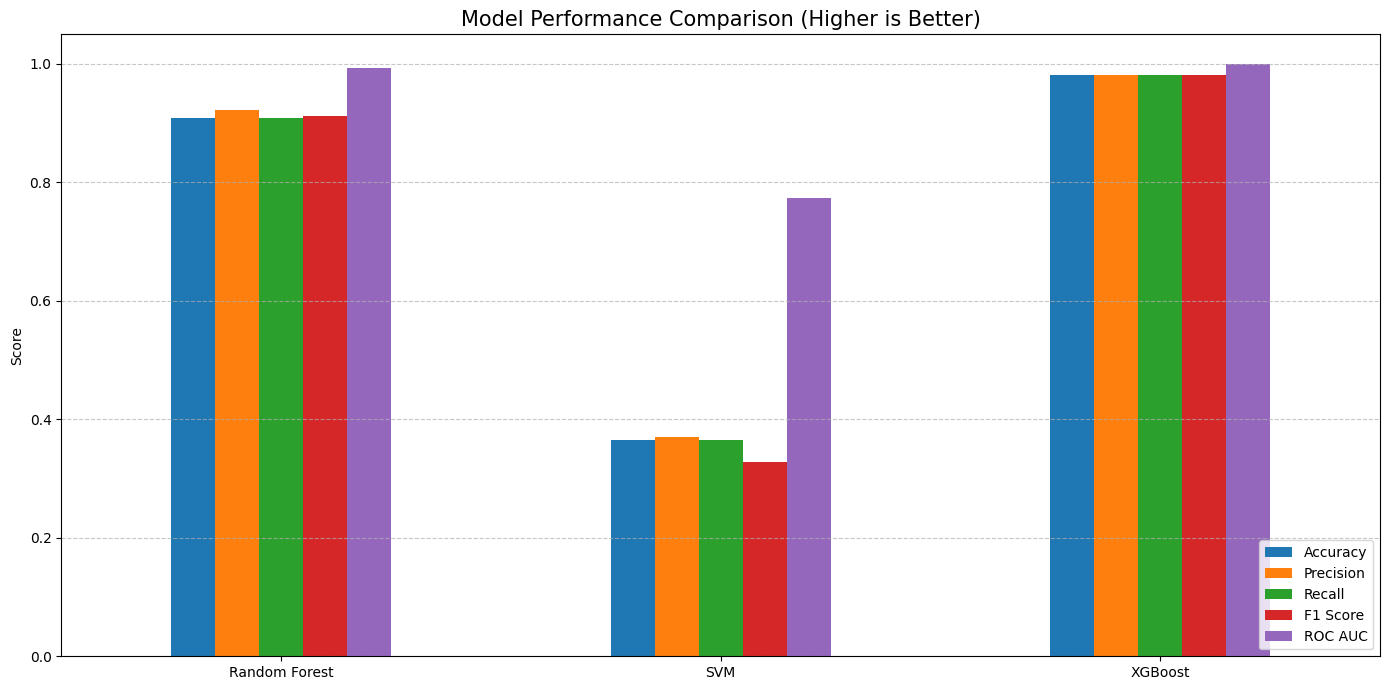

In [ ]:
# Plot performance metrics comparison
plt.figure(figsize=(14, 8))
df_results[metrics].plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance Comparison (Higher is Better)', fontsize=15)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


ROC and Precision-Recall curves not shown for multiclass classification.


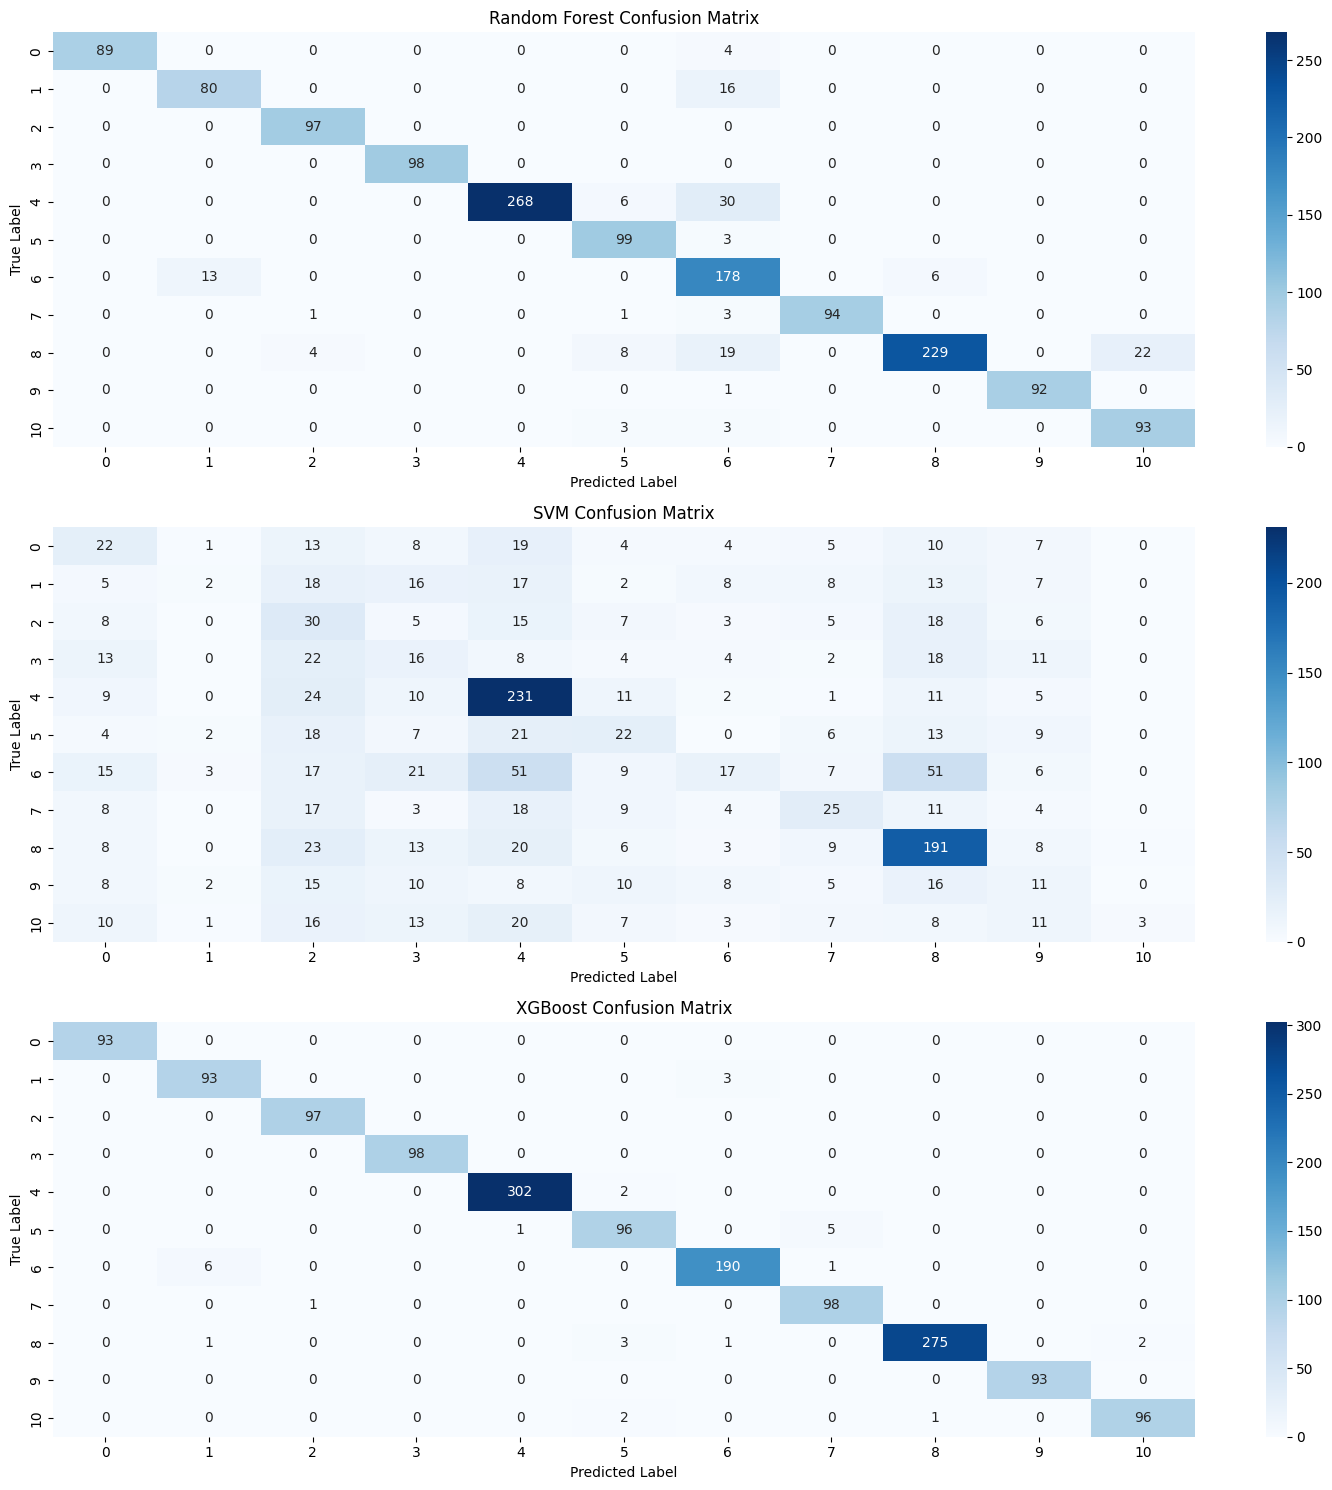

In [ ]:
# Check if we're working with binary classification
is_binary = results[list(models.keys())[0]]['is_binary']

if is_binary:
    # Plot ROC curves for binary classification
    plt.figure(figsize=(10, 8))
    for name in models.keys():
        if results[name]['y_prob'] is not None:
            try:
                fpr, tpr, _ = roc_curve(y_test, results[name]['y_prob'])
                plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.4f})")
            except Exception as e:
                print(f"Could not plot ROC curve for {name}: {e}")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison', fontsize=15)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    # Plot Precision-Recall curves for binary classification
    plt.figure(figsize=(10, 8))
    for name in models.keys():
        if results[name]['y_prob'] is not None and results[name]['PR AUC'] is not None:
            try:
                precision, recall, _ = precision_recall_curve(y_test, results[name]['y_prob'])
                plt.plot(recall, precision, label=f"{name} (AUC = {results[name]['PR AUC']:.4f})")
            except Exception as e:
                print(f"Could not plot PR curve for {name}: {e}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison', fontsize=15)
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("\nROC and Precision-Recall curves not shown for multiclass classification.")

    # For multiclass, show confusion matrices instead
    plt.figure(figsize=(15, 5 * len(models)))
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(len(models), 1, i+1)
        cm = confusion_matrix(y_test, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=results[name]['classes'],
                    yticklabels=results[name]['classes'])
        plt.title(f'{name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
    plt.show()

In [ ]:
# Compare the negative metrics (lower is better)
neg_metrics = ['Training Time']
if all(results[model_name]['Log Loss'] is not None for model_name in models.keys()):
    neg_metrics.append('Log Loss')
if all(results[model_name]['CV Std'] is not None for model_name in models.keys()):
    neg_metrics.append('CV Std')

df_neg_results = pd.DataFrame({
    model_name: {metric: results[model_name][metric] for metric in neg_metrics if results[model_name][metric] is not None}
    for model_name in models.keys()
}).T

<Figure size 1200x600 with 0 Axes>

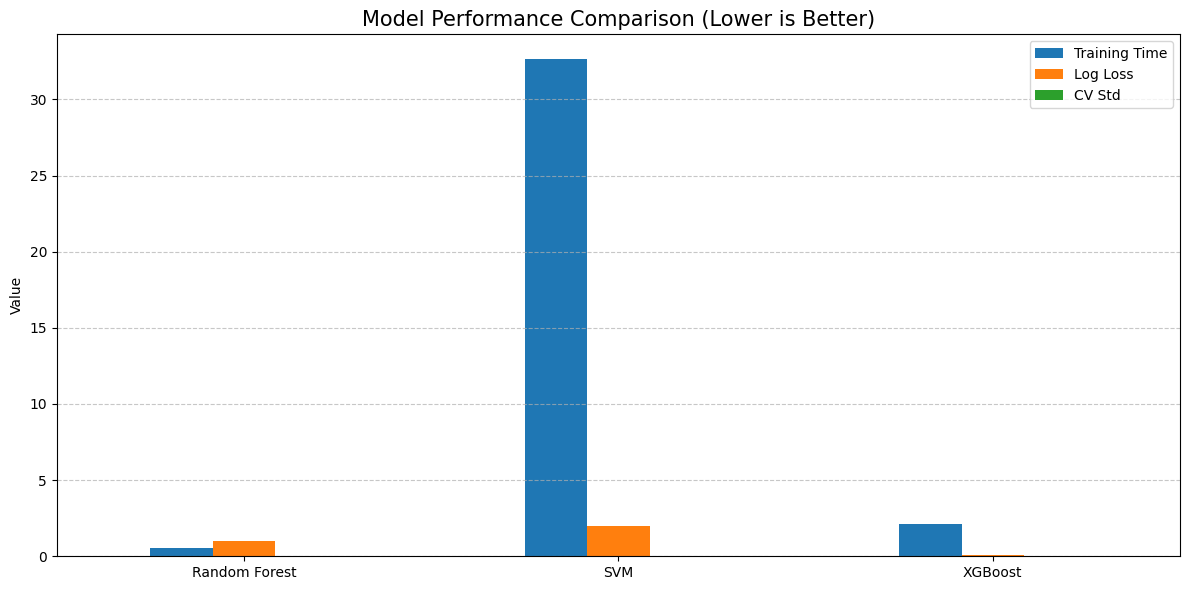

In [ ]:
plt.figure(figsize=(12, 6))
df_neg_results.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison (Lower is Better)', fontsize=15)
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()